In [1]:
import numpy as np
import math
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.svm import SVC
from torch.nn import RNN
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data = pd.read_csv("IMU_activities.csv")


In [3]:
emptyDf = pd.DataFrame(columns=["Accelerometer X", "Accelerometer Y", "Accelerometer Z", "label"])

In [57]:
# # WARNING: THIS TAKES VERY LONG
dfs = []
def group_data(dataset):
    lastVal = 1

    df = pd.DataFrame(columns=["Accelerometer X", "Accelerometer Y", "Accelerometer Z", "label"])
    length = len(dataset)
    for i in range(length):
        label = dataset['label'][i]
        if lastVal != label:
            dfs.append(df)
            df = pd.DataFrame(columns=["Accelerometer X", "Accelerometer Y", "Accelerometer Z", "label"])
            lastVal = label

        df.loc[i] = data.iloc[i]

    if len(df) > 0:
        dfs.append(df)

# group_data(data)

In [56]:
import random
from scipy.stats import zscore

randomised = random.sample(dfs, len(dfs))
data = emptyDf

def categorise(category):
    if category in [13,14,15,16,17]:
        return 3
    elif category == 10:
        return 2
    elif category in [2,3]:
        return 1
    else:
        return 0

def get_renumbered_labels(data):
    unique_labels = np.unique(data['label'].values)
    label_mapping = {old_label: categorise(old_label) for _, old_label in enumerate(unique_labels, 0)}
    # label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels, 0)}
    renumbered_labels = ([label_mapping[label] for label in data.iloc[:,3].values])
    return renumbered_labels


def normalise(data):
#     cols = data.select_
    cols = data.columns[:3]
    data[cols] = data[cols].apply(zscore)
    return data


def relabel_data(data):
    renumbered_labels = get_renumbered_labels(data)
    relabelled_data = data.drop('label', axis=1)
    # print(relabelled_data)
    # result = pd.concat([relabelled_data, pd.DataFrame(renumbered_labels)], ignore_index=True)
    relabelled_data['label'] = renumbered_labels
    return relabelled_data



for i in range(len(randomised)):
    df = randomised[i]
    df = normalise(df)
    data = pd.concat([data, df])

data = relabel_data(data)
renumbered_labels = get_renumbered_labels(data)

In [31]:
#  hypter params
num_classes=4
input_size=3
batch_size=32
n_layers=2
hidden_size=64
output_size=4
learning_rate=0.001
num_epochs = 75
one_second = 200 # determined by seeing that group A activities done for ~150s and the first 30,000 rows are all category 1
step_size= int(one_second) # 200 = 1s
look_back= 15
TRAIN_PERCENT = 0.8
categories = np.unique(renumbered_labels)

In [43]:
data

,Accelerometer X,Accelerometer Y,Accelerometer Z,label
30720,0.195953,3.299271,-0.607923,1
30721,-0.126063,3.288326,-0.606397,1
30722,-0.559557,3.024088,0.235017,1
30723,-0.618015,2.689613,0.595125,1
30724,-0.622643,2.274185,-0.363796,1
...,...,...,...,...
30715,1.071616,-0.598158,-0.295616,0
30716,0.757409,-0.455602,-0.347744,0
30717,0.757180,-0.455632,-0.295320,0
30718,1.072074,-0.598100,-0.400463,0


In [32]:

def convert_to_ohc(data, labels, num_classes):
    ohc = F.one_hot(torch.tensor(labels), num_classes = num_classes)
    data.drop(['label'], axis=1, inplace=True)
    encoded_df = pd.DataFrame(ohc,index=data.index)

    # print(encoded)
    data = pd.concat([data, encoded_df], axis=1, ignore_index=True)
    return data

def group_segment(dataset, look_back=look_back):
    look_back = look_back*step_size
    dataX, dataY = [], []
    iterations = math.floor((len(dataset)-look_back)/step_size)
    for i in range(iterations):
        step = i*step_size
        feature = np.array(dataset.iloc[step:step+look_back:step_size, :3].values, dtype='f')
#         target = np.array(dataset.iloc[step+step_size:step+step_size+look_back:step_size, 3:].values, dtype='f')
        target = np.array(dataset.iloc[step+step_size+look_back, 3:].values, dtype='f')
        dataX.append(feature)
        dataY.append(target)
        
    dataY = F.one_hot(torch.Tensor(dataY).to(torch.int64), num_classes = num_classes)
    return torch.Tensor(np.array(dataX)), torch.Tensor(np.array(dataY))


relax = (data[data['label'] == 0])
fine_motor = (data[data['label'].isin([1])])
eating = (data[data['label'].isin([2])])
mobility = (data[data['label'].isin([3])])

relaxX, relaxY = group_segment(relax)
fine_motorX, fine_motorY = group_segment(fine_motor)
eatingX, eatingY = group_segment(eating)
mobilityX, mobilityY = group_segment(mobility)

minLabels = relaxX

fine_motor_indexes = random.sample(range(len(fine_motorX)), len(minLabels))
X = np.empty(shape=[0, look_back, 3])

fine_motor_resampled = np.empty(shape=[0, look_back, 3])
for i in fine_motor_indexes:
    fine_motor_resampled = np.append(fine_motor_resampled, [fine_motorX[i].tolist()], axis=0)


eating_indexes = random.sample(range(len(eatingX)), len(minLabels))
eating_resampled = np.empty(shape=[0, look_back, 3])
for i in eating_indexes:
    eating_resampled = np.append(eating_resampled, [eatingX[i].tolist()], axis=0)

mobility_indexes = random.sample(range(len(mobilityX)), len(minLabels))
mobility_resampled = np.empty(shape=[0, look_back, 3])
for i in mobility_indexes:
    mobility_resampled = np.append(mobility_resampled, [mobilityX[i].tolist()], axis=0)

X = np.append(X, relaxX, axis=0)
X = np.append(X, fine_motorX, axis=0)
X = np.append(X, eatingX, axis=0)
X = np.append(X, mobilityX, axis=0)

print(fine_motorY.shape)
Y = np.empty(shape=[0, 4])
Y = np.append(Y, [[1, 0, 0, 0]]*len(relaxY), axis=0)
Y = np.append(Y, [[0, 1, 0, 0]]*len(fine_motorY), axis=0)
Y = np.append(Y, [[0, 0, 1, 0]]*len(eatingY), axis=0)
Y = np.append(Y, [[0, 0, 0, 1]]*len(mobilityY), axis=0)


print(X.shape)
print(Y.shape)
X = torch.Tensor(X)
Y = torch.Tensor(Y)


torch.Size([292, 1, 4])
(980, 15, 3)
(980, 4)


In [33]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2)

In [34]:
# trainY = trainY[:,-1,:]
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation for inference
        for data, labels in data_loader:
            data = data.to(device)
            outputs = model(data)
            max_indices = torch.argmax(outputs, dim=1)
            ohc = torch.zeros_like(labels)
            ohc.scatter_(1, max_indices.view(-1, 1), 1)
            for i in range((ohc.size(0))):
                output = ohc[i]
                label = labels[i]
                if torch.equal(output, label):
                    correct += 1
            total+= labels.size(0)
    
    accuracy = correct / total
    return accuracy

In [35]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.output(x[:,-1,:])
        x = F.softmax(x, dim=1)
        
        return x

model = LSTM()
model = model.to(device)
optimiser = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

train_loader = DataLoader(TensorDataset(train_x.float(), train_y.float()), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_x.float(), test_y.float()), batch_size=batch_size)
# 


In [36]:
# for x, y in train_loader:
#     print(y[0])
#     print(x[0][-1])
#     print(x[1][-1-1])

In [37]:

for epoch in range(num_epochs):
    model.train()
    for x, y in train_loader:
        pred = model(x)
        y = y.float()
        loss = (loss_fn(pred, y))
#         loss.requires_grad = True
        optimiser.zero_grad()    
        loss.backward()
        
        optimiser.step()
        
    if epoch % 2 != 0:
        continue
    model.eval()
        
    with torch.no_grad():
        train_acc = calculate_accuracy(model, train_loader, device)*100
        test_acc = calculate_accuracy(model, test_loader, device)*100
        print("Epoch %d: train acc %.3f, test acc %.3f" % (epoch, train_acc, test_acc))
        
#     with torch.no_grad():
#         pred = model(train_x)
# #         trainY = train_y.float()
#         train_rmse = (loss_fn(pred, train_y))
        
#         pred = model(test_x)
# #         testY = testY.float()
#         test_rmse = (loss_fn(pred, test_y))
        
#         print("Epoch %d: train loss %.4f, test loss %.4f" % (epoch, train_rmse, test_rmse))
# #         print("Epoch %d: train acc %.4f, test acc %.4f" % (epoch, train_acc, test_acc))


Epoch 0: train acc 42.602, test acc 39.796
Epoch 2: train acc 42.602, test acc 39.796
Epoch 4: train acc 58.546, test acc 55.612
Epoch 6: train acc 69.133, test acc 67.857
Epoch 8: train acc 71.811, test acc 68.367
Epoch 10: train acc 72.577, test acc 68.878
Epoch 12: train acc 72.577, test acc 68.878
Epoch 14: train acc 76.020, test acc 71.429
Epoch 16: train acc 75.893, test acc 72.449
Epoch 18: train acc 78.444, test acc 73.980
Epoch 20: train acc 78.571, test acc 73.469
Epoch 22: train acc 79.082, test acc 73.980
Epoch 24: train acc 79.082, test acc 73.980
Epoch 26: train acc 80.230, test acc 71.939
Epoch 28: train acc 80.102, test acc 77.551
Epoch 30: train acc 83.418, test acc 78.571
Epoch 32: train acc 84.184, test acc 83.163
Epoch 34: train acc 87.628, test acc 84.694
Epoch 36: train acc 90.434, test acc 85.714
Epoch 38: train acc 92.092, test acc 88.776
Epoch 40: train acc 92.602, test acc 89.286
Epoch 42: train acc 89.541, test acc 86.735
Epoch 44: train acc 94.133, test acc 

In [39]:
model.state_dict()
PATH = "./activity-classification-new.pth"
torch.save(model.state_dict(), PATH)
model(train_x)

tensor([[1.4713e-04, 9.9979e-01, 4.0901e-05, 2.1970e-05],
        [3.9106e-05, 1.7435e-05, 8.9000e-06, 9.9993e-01],
        [4.6676e-05, 1.7749e-05, 9.3527e-06, 9.9993e-01],
        ...,
        [4.0319e-05, 1.6930e-05, 1.0838e-05, 9.9993e-01],
        [1.2982e-05, 9.9998e-01, 1.9355e-06, 5.6381e-06],
        [1.4512e-05, 9.9998e-01, 2.2506e-07, 1.7043e-06]],
       grad_fn=<SoftmaxBackward0>)

# Testing Model Performance

Train Loss: 0.746558

Train Accuracy of     0: 99% (108/109)
Train Accuracy of     1: 99% (234/235)
Train Accuracy of     2: 100% (106/106)
Train Accuracy of     3: 100% (334/334)

Train Accuracy (Overall): 99% (782/784)


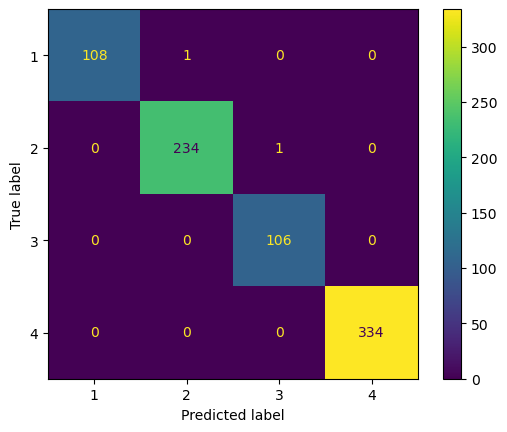

In [55]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
NUM_CLASSES = 4

train_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []

model.eval()

for i, (x, y) in enumerate(train_loader):
    (x, y) = (x.to(device), y.to(torch.float32).to(device))
    output = model(x)
    loss = loss_fn(output, y)
    train_loss += loss.item() * x.size(0)
    _, pred = torch.max(output, 1)   
    _, y = torch.max(y, 1)
    actual.extend(y)
    predicted.extend(pred)
    correct_tensor = pred.eq(y)
    correct = np.squeeze(correct_tensor)
    for i in range(len(y.data)):
        label = y.data[i]
        class_correct[label] += correct[i].item() 
        class_total[label] += 1

train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(NUM_CLASSES):
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
        i, 100.0 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

#metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


test_loss: 1.413722



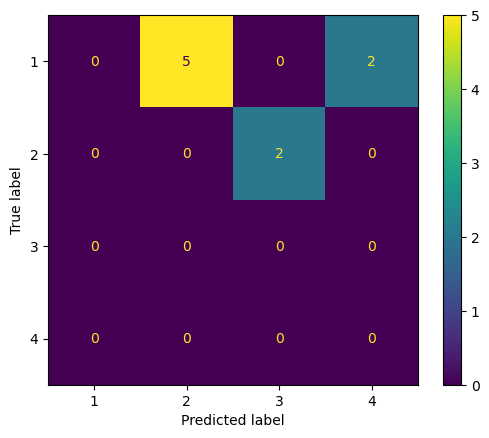

In [52]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
NUM_CLASSES = 4

test_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []

model.eval()

for i, (x, y) in enumerate(test_loader):
    (x, y) = (x.to(device), y.to(torch.float32).to(device))
    output = model(x)
    loss = loss_fn(output, y)
    test_loss += loss.item() * x.size(0)
    _, pred = torch.max(output, 1)   
    _, y = torch.max(y, 1)
    actual.extend(y)
    predicted.extend(pred)

test_loss = test_loss/len(test_loader.dataset)
print('test_loss: {:.6f}\n'.format(test_loss))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

#metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


# Testing

In [55]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

In [56]:
data

,Accelerometer X,Accelerometer Y,Accelerometer Z,label
197120,0.288872,0.836830,0.130019,3
197121,0.259501,0.868650,0.121342,3
197122,0.255164,0.868554,0.138809,3
197123,0.264476,0.901172,0.138778,3
197124,0.282042,0.917750,0.134370,3
...,...,...,...,...
30715,0.716926,0.030810,0.731656,0
30716,0.704212,0.038655,0.727316,0
30717,0.704203,0.038653,0.731680,0
30718,0.716944,0.030813,0.722927,0


1

In [44]:
sampling_rate = 40
test_data = pd.read_csv("test_data.csv")
# def convert_to_ohc(data, labels, num_classes):
#     ohc = F.one_hot(torch.tensor(labels), num_classes = num_classes)
#     data.drop(['label'], axis=1, inplace=True)
#     encoded_df = pd.DataFrame(ohc,index=data.index)

#     # print(encoded)
#     data = pd.concat([data, encoded_df], axis=1, ignore_index=True)
#     return data
# test_data
# def normalise_imu_data(data):
    
test_renumbered_labels = get_renumbered_labels(test_data)
test_data = convert_to_ohc(test_data, test_renumbered_labels, 4)

In [45]:
group_segment(test_data)
# trainY = trainY[:,-1,:]
# testY = testY[:,-1,:]

testX



In [46]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, 2, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.output(x[:,-1,:])
        x = F.softmax(x, dim=1)
        
        return x

model = LSTM()
model = model.to(device)
optimiser = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

file_path = "./activity-classification-new.pth"
model.load_state_dict(torch.load(file_path))
model.eval()
test_loader = DataLoader(TensorDataset(testX.float(), testY.float()), batch_size=batch_size)

In [47]:
predY = model(testX)
print(testX.shape)
acc = calculate_accuracy(model, test_loader, device)*100
print(acc)

torch.Size([9, 1, 3])
0.0
